# Plot localization functions for single column

In [1]:
import numpy as np
import xarray as xr
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import optimize

In [2]:
cd /Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts


In [3]:
from post_processing_fns import *
from letkf import *

In [4]:
these_columns = {
  'lons' : [-154.5, 35.5, 75.5, -150.5, 160.5],
  'lats' : [-27.5, -49.5, -31.5, 12.5, 40.5],
  'name' : ['South Pacific', 'Southern Ocean', 'Indian Ocean', 'Tropical Pacific', 'North Pacific'],
  'save_name' : ['south_pacific2', 'southern_ocean2', 'indian_ocean2', 'tropical_pacific2', 'north_pacific']
}

In [5]:
## Where are we working
proj_dir = '/Users/zstanley/Documents/git_repos/obs_loc_for_scda'
plot_dir = proj_dir + '/plots/paper/'
my_data_dir = proj_dir + '/my_data/20151206.030000'
nb_dir = proj_dir + '/notebooks'

In [6]:
raisin_black = [45/256, 42/256, 50/256]
heliotrope_gray = [162/256, 155/256, 171/256]
pacific_blue = [37/256, 162/256, 192/256]
deep_saffron = [255/256, 145/256, 51/256]

## Load correlations

In [7]:
# Load correlation matrices
sp_corr_mat = np.load(my_data_dir +'/'+these_columns['save_name'][0]+'_cor.npy')
so_corr_mat = np.load(my_data_dir +'/'+these_columns['save_name'][1]+'_cor.npy')
io_corr_mat = np.load(my_data_dir +'/'+these_columns['save_name'][2]+'_cor.npy')
tp_corr_mat = np.load(my_data_dir +'/'+these_columns['save_name'][3]+'_cor.npy')
np_corr_mat = np.load(my_data_dir +'/'+these_columns['save_name'][4]+'_cor.npy')

In [8]:
# Load covariance matrices
sp_cov_mat = np.load(my_data_dir +'/'+these_columns['save_name'][0]+'_cov.npy')
so_cov_mat = np.load(my_data_dir +'/'+these_columns['save_name'][1]+'_cov.npy')
io_cov_mat = np.load(my_data_dir +'/'+these_columns['save_name'][2]+'_cov.npy')
tp_cov_mat = np.load(my_data_dir +'/'+these_columns['save_name'][3]+'_cov.npy')
np_cov_mat = np.load(my_data_dir +'/'+these_columns['save_name'][4]+'_cov.npy')

In [9]:
## Load vertical columns
south_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][0]+'.nc')
southern_ocean = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][1]+'.nc')
indian_ocean = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][2]+'.nc')
tropical_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][3]+'.nc')
north_pacific = xr.open_dataset(my_data_dir+'/five_columns_'+these_columns['save_name'][4]+'.nc')

In [10]:
def ast_sst_corr_from_column(column):
    ds_corr = xr.Dataset()
    ds_corr['sst_atm_T'] = xr.corr(column['sst'], column['atm_T'], dim = 'ens_mem')
    ds_corr['sst_ocn_T'] = xr.corr(column['sst'], column['ocn_Temp'], dim = 'ens_mem')
    ds_corr['ast_atm_T'] = xr.corr(column['atm_t2m'], column['atm_T'], dim = 'ens_mem')
    ds_corr['ast_ocn_T'] = xr.corr(column['atm_t2m'], column['ocn_Temp'], dim = 'ens_mem')
    ds_corr['ocn_z'] = column['ocn_h'].mean(['ens_mem', 'lat', 'lon']).cumsum(dim='ocn_lev')
    ds_corr['atm_p'] = column['atm_delp'].mean(['ens_mem', 'lat', 'lon']).cumsum(dim='atm_lev') / 1e2
    ds_corr = ds_corr.mean(['lat', 'lon'])
    return ds_corr

In [11]:
## Store ast and sst correlations
sp_corr = ast_sst_corr_from_column(south_pacific)
so_corr = ast_sst_corr_from_column(southern_ocean)
io_corr = ast_sst_corr_from_column(indian_ocean)
tp_corr = ast_sst_corr_from_column(tropical_pacific)
np_corr = ast_sst_corr_from_column(north_pacific)

In [12]:
## Get indices
# atmosphere
num_atm_levs = len(south_pacific['atm_lev'])
indt2m = num_atm_levs - 1
ind100hPa = np.argmin(np.abs(sp_corr['atm_p'].values-100))
ind500hPa = np.argmin(np.abs(sp_corr['atm_p'].values-500))
# ocean
ind0m = num_atm_levs
ind150m_ocn = np.argmin(np.abs(sp_corr['ocn_z'].values-150))
ind500m_ocn = np.argmin(np.abs(sp_corr['ocn_z'].values-500))
ind400m_ocn = np.argmin(np.abs(sp_corr['ocn_z'].values-400))
ind150m = ind0m + ind150m_ocn
ind500m = ind0m + ind500m_ocn
num_ocn_levs = len(south_pacific['ocn_lev'])

In [13]:
def get_ens_corr(corr_sqrt, ens_size):
    num_levs = corr_sqrt.shape[0]
    rnd = np.random.normal(size=(num_levs, ens_size))
    x_err_ens = corr_sqrt @ rnd
    C_ens = np.corrcoef(x_err_ens)
    return C_ens

In [14]:
def get_ens_cov(cov_sqrt, ens_size):
    num_levs = cov_sqrt.shape[0]
    rnd = np.random.normal(size=(num_levs, ens_size))
    x_err_ens = cov_sqrt @ rnd
    P_ens = np.cov(x_err_ens)
    return P_ens

In [15]:
def get_multiple_ens_corrs(corr_sqrt, ens_size, ind_ob, num_trials):
    corr_cols = np.empty([corr_sqrt.shape[0], num_trials])
    for ii in range(num_trials):
        ens_corr_mat = get_ens_corr(corr_sqrt, ens_size)
        ens_cor_col = ens_corr_mat[:, ind_ob]
        corr_cols[:, ii] = ens_cor_col
    return corr_cols

In [16]:
def get_multiple_ens_covs(cov_sqrt, ens_size, ind_ob, num_trials):
    cov_cols = np.empty([cov_sqrt.shape[0], num_trials])
    for ii in range(num_trials):
        ens_cov_mat = get_ens_cov(cov_sqrt, ens_size)
        ens_cov_col = ens_cov_mat[:, ind_ob]
        cov_cols[:, ii] = ens_cov_col
    return cov_cols

In [17]:
def bump(avg_squared_correlations, ens_size):
    prefactor = (ens_size - 1) / ( (ens_size+1) * (ens_size-2) )
    opt_loc = prefactor * ( (ens_size-1) - np.reciprocal(avg_squared_correlations))
    #prefactor = (ens_size - 1 ) / (ens_size**2)
    #opt_loc = prefactor * ( ens_size - np.reciprocal(avg_squared_correlations) )
    return opt_loc

In [18]:
ind_state = np.arange(ind100hPa, ind500m)
ind_ast = ind0m - ind100hPa - 1
ind_sst = ind_ast + 1

In [19]:
tp_corr_mat_clipped = tp_corr_mat[np.ix_(ind_state, ind_state)]
tp_corr_sqrt = np.linalg.cholesky(tp_corr_mat_clipped)

In [20]:
tp_cov_mat_clipped = tp_cov_mat[np.ix_(ind_state, ind_state)]
tp_cov_sqrt = np.linalg.cholesky(tp_cov_mat_clipped)

In [21]:
ens_corr_ast = get_multiple_ens_corrs(tp_corr_sqrt, 20, ind_ast, 1000)
ens_corr_sst = get_multiple_ens_corrs(tp_corr_sqrt, 20, ind_sst, 1000)

In [22]:
ens_cov_ast = get_multiple_ens_covs(tp_cov_sqrt, 20, ind_ast, 1000)
ens_cov_sst = get_multiple_ens_covs(tp_cov_sqrt, 20, ind_sst, 1000)

In [23]:
true_corr_ast = tp_corr_mat_clipped[ind_ast, :]
true_corr_sst = tp_corr_mat_clipped[ind_sst, :]

In [24]:
true_cov_ast = tp_cov_mat_clipped[ind_ast, :]
true_cov_sst = tp_cov_mat_clipped[ind_sst, :]

In [25]:
# AST
ens_corr_ast_avg = np.mean(ens_corr_ast, axis=1)
ens_corr_ast_std = np.std(ens_corr_ast, axis=1)
ens_corr_ast_p05 = np.percentile(ens_corr_ast, 5, axis=1)
ens_corr_ast_p95 = np.percentile(ens_corr_ast, 95, axis=1)
ens_corr_ast_sdl = ens_corr_ast_avg - ens_corr_ast_std
ens_corr_ast_sdu = ens_corr_ast_avg + ens_corr_ast_std
# SST
ens_corr_sst_avg = np.mean(ens_corr_sst, axis=1)
ens_corr_sst_std = np.std(ens_corr_sst, axis=1)
ens_corr_sst_p05 = np.percentile(ens_corr_sst, 5, axis=1)
ens_corr_sst_p95 = np.percentile(ens_corr_sst, 95, axis=1)
ens_corr_sst_sdl = ens_corr_sst_avg - ens_corr_sst_std
ens_corr_sst_sdu = ens_corr_sst_avg + ens_corr_sst_std

## Get optimal localization weights

In [26]:
ens_true_prod_ast = ens_corr_ast * np.tile(true_corr_ast, [1000,1]).transpose()
ens_true_prod_sst = ens_corr_sst * np.tile(true_corr_sst, [1000,1]).transpose()

In [27]:
ens_square_ast = np.square(ens_corr_ast)
ens_square_sst = np.square(ens_corr_sst)

In [28]:
opt_loc_ast = np.divide( np.sum(ens_true_prod_ast, axis=1), np.sum(ens_square_ast, axis=1) )
opt_loc_sst = np.divide( np.sum(ens_true_prod_sst, axis=1), np.sum(ens_square_sst, axis=1) )

In [29]:
ens_true_prod_cov_ast = ens_cov_ast * np.tile(true_cov_ast, [1000,1]).transpose()
ens_true_prod_cov_sst = ens_cov_sst * np.tile(true_cov_sst, [1000,1]).transpose()

In [30]:
ens_square_cov_ast = np.square(ens_cov_ast)
ens_square_cov_sst = np.square(ens_cov_sst)

In [31]:
opt_loc_cov_ast = np.divide( np.sum(ens_true_prod_cov_ast, axis=1), np.sum(ens_square_cov_ast, axis=1) )
opt_loc_cov_sst = np.divide( np.sum(ens_true_prod_cov_sst, axis=1), np.sum(ens_square_cov_sst, axis=1) )

In [32]:
bump_ast = bump(np.mean(ens_square_ast, axis=1), 20)
bump_sst = bump(np.mean(ens_square_sst, axis=1), 20)

## Find optimal R-localization

In [33]:
def kalman_gain_error_by_level(loc_weight, true_gain, ens_covs, r, ind_ob, lev):
    true_gain = true_gain[lev]
    denom = ( ens_covs[ind_ob, :] + loc_weight * r)
    ens_gains = ens_covs[lev, :] / denom
    error = np.sum( np.square(true_gain - ens_gains) )
    return error

In [34]:
tp_cov_mat_clipped = tp_cov_mat[np.ix_(ind_state, ind_state)]
tp_cov_sqrt = np.linalg.cholesky(tp_cov_mat_clipped)

In [35]:
ens_cov_ast = get_multiple_ens_covs(tp_cov_sqrt, 20, ind_ast, 1000)
ens_cov_sst = get_multiple_ens_covs(tp_cov_sqrt, 20, ind_sst, 1000)

In [36]:
true_cov_ast = tp_cov_mat_clipped[ind_ast, :]
true_cov_sst = tp_cov_mat_clipped[ind_sst, :]

In [37]:
R_ast = true_cov_ast[ind_ast]
R_sst = true_cov_sst[ind_sst]

In [38]:
true_kalman_gain_ast = true_cov_ast / (2*R_ast)
true_kalman_gain_sst = true_cov_sst / (2*R_sst)

In [39]:
num_levs = len(true_kalman_gain_ast)
r_loc_ast = np.empty(num_levs)
r_loc_sst = np.empty(num_levs)
for level in range(num_levs):
    result_ast = optimize.minimize_scalar(kalman_gain_error_by_level, args=(true_kalman_gain_ast, ens_cov_ast, R_ast, ind_ast, level))
    result_sst = optimize.minimize_scalar(kalman_gain_error_by_level, args=(true_kalman_gain_sst, ens_cov_sst, R_sst, ind_sst, level))
    r_loc_ast[level] = result_ast.x
    r_loc_sst[level] = result_sst.x

In [40]:
# Ensemble Kalman gain for ast
ens_k_ast  = ens_cov_ast / ( np.tile(ens_cov_ast[ind_ast,:], [num_levs,1]) + R_ast * np.tile(r_loc_ast, [1000,1]).transpose() )
ens_k_unloc_ast  = ens_cov_ast / ( np.tile(ens_cov_ast[ind_ast,:], [num_levs,1]) + R_ast )
effective_loc_ast = np.mean(np.divide(ens_k_ast, ens_k_unloc_ast), axis=1)
# Ensemble Kalman gain for sst
ens_k_sst  = ens_cov_sst / ( np.tile(ens_cov_sst[ind_sst,:], [num_levs,1]) + R_sst * np.tile(r_loc_sst, [1000,1]).transpose() )
ens_k_unloc_sst  = ens_cov_sst / ( np.tile(ens_cov_sst[ind_sst,:], [num_levs,1]) + R_sst )
effective_loc_sst = np.mean(np.divide(ens_k_sst, ens_k_unloc_sst), axis=1)

## Find optimal GC localization

In [41]:
def error_corr_with_gc_no_factor(loc_rad, true_corr, ens_corrs, dist):
    ''' Error in correlation matrix (model space) '''
    num_levs, num_trials = ens_corrs.shape
    loc = gaspari_cohn(dist/(loc_rad/2))
    loc_expand = np.tile(loc, [num_trials, 1]).transpose()
    true_corr_expand = np.tile(true_corr, [num_trials, 1]).transpose()
    error = np.mean(np.square(true_corr_expand - loc_expand * ens_corrs))
    return error

In [42]:
def error_corr_with_gc(inputs, true_corr, ens_corrs, dist):
    ''' Error in correlation matrix (model space) '''
    loc_rad = inputs[0]
    mult_factor = inputs[1]
    num_levs, num_trials = ens_corrs.shape
    loc = mult_factor * gaspari_cohn(dist/(loc_rad/2))
    loc_expand = np.tile(loc, [num_trials, 1]).transpose()
    true_corr_expand = np.tile(true_corr, [num_trials, 1]).transpose()
    error = np.mean(np.square(true_corr_expand - loc_expand * ens_corrs))
    return error

In [43]:
ocn_z = tp_corr['ocn_z'][:ind500m_ocn]
atm_p = tp_corr['atm_p'][ind100hPa:]

In [44]:
dist_ocn = ocn_z - ocn_z[0]
dist_atm = np.abs(np.log(atm_p) - np.log(atm_p[-1]))

In [45]:
# Ensemble correlations
ens_corr_ast_atm = ens_corr_ast[:ind_sst, :]
ens_corr_ast_ocn = ens_corr_ast[ind_sst:, :]
ens_corr_sst_atm = ens_corr_sst[:ind_sst, :]
ens_corr_sst_ocn = ens_corr_sst[ind_sst:, :]
# True correlations
true_corr_ast_atm = true_corr_ast[:ind_sst]
true_corr_ast_ocn = true_corr_ast[ind_sst:]
true_corr_sst_atm = true_corr_sst[:ind_sst]
true_corr_sst_ocn = true_corr_sst[ind_sst:]

In [46]:
# no multiplicative factor
gc_loc_rad_ast_atm = optimize.minimize_scalar(error_corr_with_gc_no_factor, args=(true_corr_ast_atm, ens_corr_ast_atm, dist_atm)).x
gc_loc_rad_ast_ocn = optimize.minimize_scalar(error_corr_with_gc_no_factor, args=(true_corr_ast_ocn, ens_corr_ast_ocn, dist_ocn)).x
gc_loc_rad_sst_atm = optimize.minimize_scalar(error_corr_with_gc_no_factor, args=(true_corr_sst_atm, ens_corr_sst_atm, dist_atm)).x
gc_loc_rad_sst_ocn = optimize.minimize_scalar(error_corr_with_gc_no_factor, args=(true_corr_sst_ocn, ens_corr_sst_ocn, dist_ocn)).x

In [47]:
# with multplicative factor
gc_locrad_multfact_ast_atm = optimize.minimize(error_corr_with_gc, x0=[.5, 1], args=(true_corr_ast_atm, ens_corr_ast_atm, dist_atm), method='nelder-mead').x
gc_locrad_multfact_ast_ocn = optimize.minimize(error_corr_with_gc, x0=[50, 1], args=(true_corr_ast_ocn, ens_corr_ast_ocn, dist_ocn), method='nelder-mead').x
gc_locrad_multfact_sst_atm = optimize.minimize(error_corr_with_gc, x0=[.5, 1], args=(true_corr_sst_atm, ens_corr_sst_atm, dist_atm), method='nelder-mead').x
gc_locrad_multfact_sst_ocn = optimize.minimize(error_corr_with_gc, x0=[50, 1], args=(true_corr_sst_ocn, ens_corr_sst_ocn, dist_ocn), method='nelder-mead').x

In [48]:
# no multiplicative factor
gc_loc_ast_atm = gaspari_cohn(dist_atm/(gc_loc_rad_ast_atm/2))
gc_loc_ast_ocn = gaspari_cohn(dist_ocn/(gc_loc_rad_ast_ocn/2))
gc_loc_sst_atm = gaspari_cohn(dist_atm/(gc_loc_rad_sst_atm/2))
gc_loc_sst_ocn = gaspari_cohn(dist_ocn/(gc_loc_rad_sst_ocn/2))
# with multiplicative factor
gc_loc_plus_ast_atm = gc_locrad_multfact_ast_atm[1] * gaspari_cohn(dist_atm/(gc_locrad_multfact_ast_atm[0]/2))
gc_loc_plus_ast_ocn = gc_locrad_multfact_ast_ocn[1] * gaspari_cohn(dist_ocn/(gc_locrad_multfact_ast_ocn[0]/2))
gc_loc_plus_sst_atm = gc_locrad_multfact_sst_atm[1] * gaspari_cohn(dist_atm/(gc_locrad_multfact_sst_atm[0]/2))
gc_loc_plus_sst_ocn = gc_locrad_multfact_sst_ocn[1] * gaspari_cohn(dist_ocn/(gc_locrad_multfact_sst_ocn[0]/2))

## Optimal GC for R-matrix localization

In [50]:
def kalman_gain_vector(ens_covs, loc, hbht, r):
    # Get shape
    num_levs, num_trials = ens_covs.shape
    # Don't divide by zero
    these_levels = (loc>0)
    loc = loc[these_levels]
    num_nonzero_levs = np.sum(these_levels)
    # Compute denominator
    loc_expand = np.tile(loc, [num_trials, 1]).transpose()
    hbht_expand = np.tile(hbht, [num_nonzero_levs, 1])
    denom = ( hbht_expand + r / loc_expand)
    # Compute ensemble gains
    ens_gains = np.zeros([num_levs, num_trials])
    ens_gains[these_levels] = np.divide(ens_covs[these_levels,:], denom)
    return ens_gains

In [51]:
def kalman_gain_vector_no_loc(ens_covs, hbht, r):
    # Get shape
    num_levs, num_trials = ens_covs.shape
    # Don't divide by zero
    # Compute denominator
    denom = ( hbht + r )
    # Compute ensemble gains
    ens_gains = np.divide(ens_covs, denom)
    return ens_gains

In [52]:
def kalman_gain_error_gc_no_atten(loc_rad, true_gain, ens_covs, r, hbht, dist):
    '''Error in Kalman gain (obs space)'''
    num_levs, num_trials = ens_covs.shape
    # Compute localization
    loc = gaspari_cohn(dist/(loc_rad/2))
    # Compute Kalman gains
    ens_gains = kalman_gain_vector(ens_covs, loc, hbht, r)
    # Compute error
    true_gain_expand = np.tile(true_gain, [num_trials, 1]).transpose()
    error = np.mean( np.square(true_gain_expand - ens_gains) )
    return error

In [53]:
def kalman_gain_error_gc(inputs, true_gain, ens_covs, r, hbht, dist):
    '''Error in Kalman gain (obs space)'''
    loc_rad = inputs[0]
    mult_factor = inputs[1]
    '''Error in Kalman gain (obs space)'''
    num_levs, num_trials = ens_covs.shape
    # Compute localization
    loc = mult_factor * gaspari_cohn(dist/(loc_rad/2))
    # Compute ensemble gains
    ens_gains = kalman_gain_vector(ens_covs, loc, hbht, r)
    # Compute error
    true_gain_expand = np.tile(true_gain, [num_trials, 1]).transpose()
    error = np.mean( np.square(true_gain_expand - ens_gains) )
    return error

In [54]:
# Ensemble covariances
ens_cov_ast_atm = ens_cov_ast[:ind_sst, :]
ens_cov_ast_ocn = ens_cov_ast[ind_sst:, :]
ens_cov_sst_atm = ens_cov_sst[:ind_sst, :]
ens_cov_sst_ocn = ens_cov_sst[ind_sst:, :]
# Ensemble HBHT
ens_cov_ast_ast = ens_cov_ast[ind_ast, :]
ens_cov_sst_sst = ens_cov_sst[ind_sst, :]
# True kalman gains
true_kalman_gain_ast_atm = true_kalman_gain_ast[:ind_sst]
true_kalman_gain_ast_ocn = true_kalman_gain_ast[ind_sst:]
true_kalman_gain_sst_atm = true_kalman_gain_sst[:ind_sst]
true_kalman_gain_sst_ocn = true_kalman_gain_sst[ind_sst:]

In [55]:
# no multiplicative factor
gc_rloc_rad_ast_atm = optimize.minimize_scalar(kalman_gain_error_gc_no_atten, args=(true_kalman_gain_ast_atm, ens_cov_ast_atm, R_ast, ens_cov_ast_ast, dist_atm)).x
gc_rloc_rad_ast_ocn = optimize.minimize_scalar(kalman_gain_error_gc_no_atten, args=(true_kalman_gain_ast_ocn, ens_cov_ast_ocn, R_ast, ens_cov_ast_ast, dist_ocn)).x
gc_rloc_rad_sst_atm = optimize.minimize_scalar(kalman_gain_error_gc_no_atten, args=(true_kalman_gain_sst_atm, ens_cov_sst_atm, R_sst, ens_cov_sst_sst, dist_atm)).x
gc_rloc_rad_sst_ocn = optimize.minimize_scalar(kalman_gain_error_gc_no_atten, args=(true_kalman_gain_sst_ocn, ens_cov_sst_ocn, R_sst, ens_cov_sst_sst, dist_ocn)).x

In [56]:
# with multplicative factor
gc_rlocrad_multfact_ast_atm = optimize.minimize(kalman_gain_error_gc, x0=[.5, 1], args=(true_kalman_gain_ast_atm, ens_cov_ast_atm, R_ast, ens_cov_ast_ast, dist_atm), method='nelder-mead').x
gc_rlocrad_multfact_ast_ocn = optimize.minimize(kalman_gain_error_gc, x0=[50, 1], args=(true_kalman_gain_ast_ocn, ens_cov_ast_ocn, R_ast, ens_cov_ast_ast, dist_ocn), method='nelder-mead').x
gc_rlocrad_multfact_sst_atm = optimize.minimize(kalman_gain_error_gc, x0=[.5, 1], args=(true_kalman_gain_sst_atm, ens_cov_sst_atm, R_sst, ens_cov_sst_sst, dist_atm), method='nelder-mead').x
gc_rlocrad_multfact_sst_ocn = optimize.minimize(kalman_gain_error_gc, x0=[50, 1], args=(true_kalman_gain_sst_ocn, ens_cov_sst_ocn, R_sst, ens_cov_sst_sst, dist_ocn), method='nelder-mead').x

In [57]:
# no multiplicative factor
gc_rloc_ast_atm = gaspari_cohn(dist_atm/(gc_rloc_rad_ast_atm/2))
gc_rloc_ast_ocn = gaspari_cohn(dist_ocn/(gc_rloc_rad_ast_ocn/2))
gc_rloc_sst_atm = gaspari_cohn(dist_atm/(gc_rloc_rad_sst_atm/2))
gc_rloc_sst_ocn = gaspari_cohn(dist_ocn/(gc_rloc_rad_sst_ocn/2))
# with multiplicative factor
gc_rloc_atten_ast_atm = gc_rlocrad_multfact_ast_atm[1] * gaspari_cohn(dist_atm/(gc_rlocrad_multfact_ast_atm[0]/2))
gc_rloc_atten_ast_ocn = gc_rlocrad_multfact_ast_ocn[1] * gaspari_cohn(dist_ocn/(gc_rlocrad_multfact_ast_ocn[0]/2))
gc_rloc_atten_sst_atm = gc_rlocrad_multfact_sst_atm[1] * gaspari_cohn(dist_atm/(gc_rlocrad_multfact_sst_atm[0]/2))
gc_rloc_atten_sst_ocn = gc_rlocrad_multfact_sst_ocn[1] * gaspari_cohn(dist_ocn/(gc_rlocrad_multfact_sst_ocn[0]/2))

In [58]:
# Ensemble Kalman gain for ast
# atm
ens_k_ast_atm  = kalman_gain_vector(ens_cov_ast_atm, gc_rloc_ast_atm, ens_cov_ast_ast, R_ast)
ens_k_atten_ast_atm  = kalman_gain_vector(ens_cov_ast_atm, gc_rloc_atten_ast_atm, ens_cov_ast_ast, R_ast)
ens_k_unloc_ast_atm  = kalman_gain_vector_no_loc(ens_cov_ast_atm, ens_cov_ast_ast, R_ast)
effective_loc_ast_atm = np.mean(np.divide(ens_k_ast_atm, ens_k_unloc_ast_atm), axis=1)
effective_loc_atten_ast_atm = np.mean(np.divide(ens_k_atten_ast_atm, ens_k_unloc_ast_atm), axis=1)
# ocn
ens_k_ast_ocn  = kalman_gain_vector(ens_cov_ast_ocn, gc_rloc_ast_ocn, ens_cov_ast_ast, R_ast)
ens_k_atten_ast_ocn  = kalman_gain_vector(ens_cov_ast_ocn, gc_rloc_atten_ast_ocn, ens_cov_ast_ast, R_ast)
ens_k_unloc_ast_ocn  = kalman_gain_vector_no_loc(ens_cov_ast_ocn, ens_cov_ast_ast, R_ast)
effective_loc_ast_ocn = np.mean(np.divide(ens_k_ast_ocn, ens_k_unloc_ast_ocn), axis=1)
effective_loc_atten_ast_ocn = np.mean(np.divide(ens_k_atten_ast_ocn, ens_k_unloc_ast_ocn), axis=1)
# Ensemble Kalman gain for sst
# atm
ens_k_sst_atm  = kalman_gain_vector(ens_cov_sst_atm, gc_rloc_sst_atm, ens_cov_sst_sst, R_sst)
ens_k_atten_sst_atm  = kalman_gain_vector(ens_cov_sst_atm, gc_rloc_atten_sst_atm, ens_cov_sst_sst, R_sst)
ens_k_unloc_sst_atm  = kalman_gain_vector_no_loc(ens_cov_sst_atm, ens_cov_sst_sst, R_sst)
effective_loc_sst_atm = np.mean(np.divide(ens_k_sst_atm, ens_k_unloc_sst_atm), axis=1)
effective_loc_atten_sst_atm = np.mean(np.divide(ens_k_atten_sst_atm, ens_k_unloc_sst_atm), axis=1)
# ocn
ens_k_sst_ocn  = kalman_gain_vector(ens_cov_sst_ocn, gc_rloc_sst_ocn, ens_cov_sst_sst, R_sst)
ens_k_atten_sst_ocn  = kalman_gain_vector(ens_cov_sst_ocn, gc_rloc_atten_sst_ocn, ens_cov_sst_sst, R_sst)
ens_k_unloc_sst_ocn  = kalman_gain_vector_no_loc(ens_cov_sst_ocn, ens_cov_sst_sst, R_sst)
effective_loc_sst_ocn = np.mean(np.divide(ens_k_sst_ocn, ens_k_unloc_sst_ocn), axis=1)
effective_loc_atten_sst_ocn = np.mean(np.divide(ens_k_atten_sst_ocn, ens_k_unloc_sst_ocn), axis=1)

In [59]:
# Define colors
raisin_black       = [ 45/256,  42/256,  50/256]
yale_blue          = [  8/256,  75/256, 131/256]
maximum_blue       = [ 66/256, 191/256, 221/256]
mint_green         = [173/256, 252/256, 146/256]
golden_gate_bridge = [187/256,  68/256,  48/256]

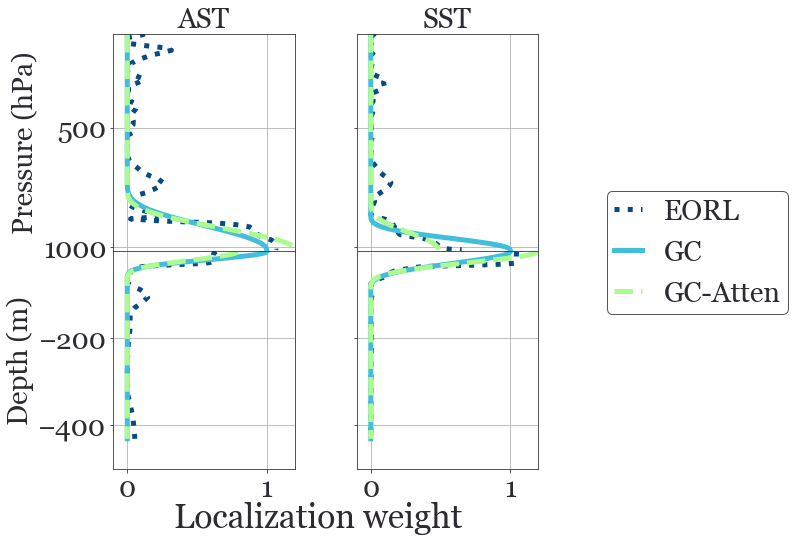

In [61]:
## Create subplots
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey='row') 

## AST
# Plot atm correlations
axs[0, 0].plot(1/r_loc_ast[:ind_sst], tp_corr['atm_p'][ind100hPa:], linewidth=5, linestyle=':',  color=yale_blue)
axs[0, 0].plot(gc_rloc_ast_atm, tp_corr['atm_p'][ind100hPa:], linewidth=5, linestyle='-',  color=maximum_blue)
axs[0, 0].plot(gc_rloc_atten_ast_atm, tp_corr['atm_p'][ind100hPa:], linewidth=5, linestyle='--', color=mint_green)

# Plot ocn correlations
axs[1, 0].plot(1/r_loc_ast[ind_sst:], -1 * tp_corr['ocn_z'][:ind500m_ocn], linewidth=5, linestyle=':',  color=yale_blue)
axs[1, 0].plot(gc_rloc_ast_ocn, -1 * tp_corr['ocn_z'][:ind500m_ocn], linewidth=5, linestyle='-',  color=maximum_blue)
axs[1, 0].plot(gc_rloc_atten_ast_ocn, -1 * tp_corr['ocn_z'][:ind500m_ocn], linewidth=5, linestyle='--', color=mint_green)

## SST
# Plot atm correlations
axs[0, 1].plot(1/r_loc_sst[:ind_sst], tp_corr['atm_p'][ind100hPa:], linewidth=5, linestyle=':',  color=yale_blue, label='EORL')
axs[0, 1].plot(gc_rloc_sst_atm, tp_corr['atm_p'][ind100hPa:], linewidth=5, linestyle='-',  color=maximum_blue, label='GC')
axs[0, 1].plot(gc_rloc_atten_sst_atm, tp_corr['atm_p'][ind100hPa:], linewidth=5, linestyle='--', color=mint_green, label='GC-Atten')

# Plot ocn correlations
axs[1, 1].plot(1/r_loc_sst[ind_sst:], -1 * tp_corr['ocn_z'][:ind500m_ocn], linewidth=5, linestyle=':',  color=yale_blue)
axs[1, 1].plot(gc_rloc_sst_ocn, -1 * tp_corr['ocn_z'][:ind500m_ocn], linewidth=5, linestyle='-',  color=maximum_blue)
axs[1, 1].plot(gc_rloc_atten_sst_ocn, -1 * tp_corr['ocn_z'][:ind500m_ocn], linewidth=5, linestyle='--', color=mint_green)

# Set titles
axs[0,0].set_title('AST', color=raisin_black, fontsize=28)
axs[0,1].set_title('SST', color=raisin_black, fontsize=28)

# Adjust and label axes
axs[0, 0].set_xlim([-0.1, 1.2])
axs[0, 0].set_ylim([100,1019])
axs[0, 0].invert_yaxis()
axs[1, 0].set_ylim([-500,-1])
axs[0, 0].set_ylabel('Pressure (hPa)', color=raisin_black)
axs[1, 0].set_ylabel('Depth (m)', color=raisin_black)
fig.supxlabel('Localization weight', color=raisin_black)
#fig.suptitle('R-localization', color=raisin_black, fontsize=36)

# Legend
leg = fig.legend(labelcolor=raisin_black, loc='center left', bbox_to_anchor=(1, 0.5),  borderaxespad=0,  borderpad=0.25, handlelength=1, markerscale=2)
leg.get_frame().set_edgecolor(raisin_black)

# Adjust aesthetics
plt.subplots_adjust(hspace=.0)
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_box_aspect(1.2)
    ax.spines['bottom'].set_color(raisin_black)
    ax.spines['top'].set_color(raisin_black) 
    ax.spines['right'].set_color(raisin_black)
    ax.spines['left'].set_color(raisin_black)
    ax.xaxis.label.set_color(raisin_black)
    ax.yaxis.label.set_color(raisin_black)
    ax.tick_params(colors=raisin_black, which='both') 


plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams.update({'font.sans-serif':'Georgia'})
plt.rcParams.update({'font.size':28})
plt.savefig(plot_dir+'/ast_sst_eorl_gcr.pdf',  bbox_inches='tight')
plt.show()